In [1]:
import torch
from tqdm.auto import tqdm
from torch.optim import AdamW
from transformers import get_scheduler
from optree import tree_map_
import pickle
import matplotlib.pyplot as plt

import uqlib

from load import load_dataloaders, load_model

In [2]:
# Load data
train_dataloader, eval_dataloader = load_dataloaders(small=True)
num_data = len(train_dataloader.dataset)

In [3]:
# Load model (with standard Gaussian prior)
model, param_to_log_posterior = load_model(num_data=num_data)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# Turn off Dropout
model.eval()

# Move to GPU if available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device);

In [5]:
# Train (as usual, using native PyTorch) for MAP
optimizer = AdamW(model.parameters(), lr=5e-5, maximize=True)

num_epochs = 4
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)


progress_bar = tqdm(range(num_training_steps))

log_posts = []

# model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}

        log_post = param_to_log_posterior(dict(model.named_parameters()), batch)

        log_post.backward()
        log_posts.append(log_post.item())
        
        print(log_posts[-1], end='\r')

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/500 [00:00<?, ?it/s]

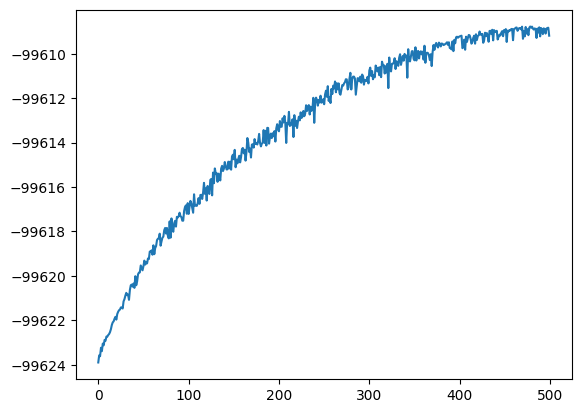

In [6]:
plt.plot(log_posts);

In [7]:
# Use uqlib for diagonal Fisher information covariance matrix
progress_bar_2 = tqdm(range(len(train_dataloader)))

laplace_state = uqlib.laplace.diag_fisher.init(dict(model.named_parameters()))

for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    laplace_state = uqlib.laplace.diag_fisher.update(
        laplace_state, param_to_log_posterior, batch
    )
    progress_bar_2.update(1)

  0%|          | 0/125 [00:00<?, ?it/s]

In [10]:
# Save state
laplace_state = tree_map_(lambda x: x.detach().cpu(), laplace_state)
pickle.dump(laplace_state, open("yelp_laplace_state.pkl", "wb"))

# laplace_state = pickle.load(open("yelp_laplace_state.pkl", "rb"))

In [9]:
# # Alternatively we could get the diagonal Hessian for the precision matrix
# progress_bar_2 = tqdm(range(len(train_dataloader)))

# laplace_state = uqlib.laplace.diag_hessian.init(dict(model.named_parameters()))

# for batch in train_dataloader:
#     batch = {k: v.to(device) for k, v in batch.items()}
#     laplace_state = uqlib.laplace.diag_hessian.update(
#         laplace_state, param_to_log_posterior, batch
#     )
#     progress_bar_2.update(1)